# Waste Classifier Improved PyTorch Model

## Goal

Improve previously attempted waste classifier `resnet50` feature extractor model by applying the following techniques:
- Increase dataset size (get more data, or better data) -> a great way to do this would be ***data augmentation*** - https://pytorch.org/vision/main/transforms.html
- Add a ***`Dropout`* layer** before the output layer - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
- Use ***learning rate decay*** - PyTorch learning rate scheduler - https://pytorch.org/docs/stable/optim.html

## 0 - Setup

In [1]:
import torch
import torchvision

print(torch.__version__) # 1.12+
print(torchvision.__version__) # 0.13+

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

from torchinfo import summary

try:
    from scripts import data_setup_augmented, engine_lr_decay, utils, predictions
    from helper_functions import download_data, set_seeds, plot_loss_curves
    print("Base imports done.")
except:
    print("Couldn't find helper scripts, downloading from Github...")
    !git clone https://github.com/tznpau/waste-classifier
    !mv waste-classifier/scripts .
    !mv waste-classifier/helper_functions.py .
    !rm -rf waste-classifier
    from scripts import data_setup_augmented, engine_lr_decay, utils, predictions
    from helper_functions import download_data, set_seeds, plot_loss_curves

2.1.1
0.16.1
Base imports done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1 - Getting data

In [3]:
trash_dataset_path = download_data(source="https://github.com/tznpau/waste-classifier/raw/main/data/trash_dataset.zip",
                                   destination="trash_dataset")
trash_dataset_path

[INFO] data\trash_dataset directory exists, skipping download.


WindowsPath('data/trash_dataset')

In [4]:
# Setup training and test data directories
train_dir = trash_dataset_path / "train"
test_dir = trash_dataset_path / "test"

train_dir, test_dir

(WindowsPath('data/trash_dataset/train'),
 WindowsPath('data/trash_dataset/test'))

## 2 - ResNet50 feature extractor

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

In [5]:
resnet50 = torchvision.models.resnet50()
# resnet50

In [6]:
# from torchinfo import summary

# summary(resnet50,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [7]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

The last layer of resnet50 is called **`fc`**.

### 2.1 Creating custom transforms (data augmentation) and DataLoaders for ResNet50

In [8]:
train_transform_resnet50 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform_resnet50 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
from scripts import data_setup_augmented

train_dataloader_resnet50, test_dataloader_resnet50, class_names = data_setup_augmented.create_dataloaders(train_dir=train_dir,
                                                                                                           test_dir=test_dir,
                                                                                                           train_transform=train_transform_resnet50,
                                                                                                           test_transform=test_transform_resnet50,
                                                                                                           batch_size=32)

In [10]:
len(train_dataloader_resnet50), len(test_dataloader_resnet50), class_names

(64, 16, ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

### 2.2 Creating a ResNet50 feature extractor

Adding a `Dropout` layer before the `Linear` ouput layer `fc` should introduce regularization and prevent overfitting.

In [11]:
def create_resnet50_model(num_classes:int=6,
                          seed:int=42,
                          dropout_prob:float=0.2):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    model = torchvision.models.resnet50(weights=weights).to(device)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_prob),
        nn.Linear(in_features=2048, out_features=num_classes)
    ).to(device)

    return model

In [12]:
resnet50= create_resnet50_model(num_classes=6, seed=42, dropout_prob=0.2)

In [13]:
resnet50.fc

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=2048, out_features=6, bias=True)
)

In [14]:
summary(resnet50,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 6]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

All the original layers of the ResNet50 architecture have been frozen, **except** for the **output layer `fc`**.

## 3 - Training

In [15]:
# from scripts import engine

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=resnet50.parameters(),
#                              lr=1e-3)

# set_seeds(42)

# resnet50_results = engine.train(model=resnet50,
#                                 train_dataloader=train_dataloader_resnet50,
#                                 test_dataloader=test_dataloader_resnet50,
#                                 epochs=10,
#                                 optimizer=optimizer,
#                                 loss_fn=loss_fn,
#                                 device=device)

In [16]:
from scripts import engine_lr_decay
from torch.optim.lr_scheduler import StepLR

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet50.parameters(),
                             lr=0.1)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

set_seeds(42)

resnet50_results = engine_lr_decay.train(model=resnet50,
                                train_dataloader=train_dataloader_resnet50,
                                test_dataloader=test_dataloader_resnet50,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                scheduler=scheduler,
                                epochs=20,
                                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6121 | train_acc: 0.6943 | test_loss: 1.9839 | test_acc: 0.7430 | lr: 0.100000
Epoch: 2 | train_loss: 1.4252 | train_acc: 0.8171 | test_loss: 2.5877 | test_acc: 0.7952 | lr: 0.100000
Epoch: 3 | train_loss: 1.2457 | train_acc: 0.8345 | test_loss: 2.6576 | test_acc: 0.7729 | lr: 0.100000
Epoch: 4 | train_loss: 1.9320 | train_acc: 0.8062 | test_loss: 2.9281 | test_acc: 0.8033 | lr: 0.100000
Epoch: 5 | train_loss: 1.3491 | train_acc: 0.8639 | test_loss: 3.1240 | test_acc: 0.7882 | lr: 0.010000
Epoch: 6 | train_loss: 0.8313 | train_acc: 0.9131 | test_loss: 1.7076 | test_acc: 0.8504 | lr: 0.010000
Epoch: 7 | train_loss: 0.5736 | train_acc: 0.9238 | test_loss: 1.8066 | test_acc: 0.8541 | lr: 0.010000
Epoch: 8 | train_loss: 0.5982 | train_acc: 0.9225 | test_loss: 1.7764 | test_acc: 0.8521 | lr: 0.010000
Epoch: 9 | train_loss: 0.5751 | train_acc: 0.9299 | test_loss: 1.8327 | test_acc: 0.8535 | lr: 0.010000
Epoch: 10 | train_loss: 0.4219 | train_acc: 0.9279 | test_loss: 

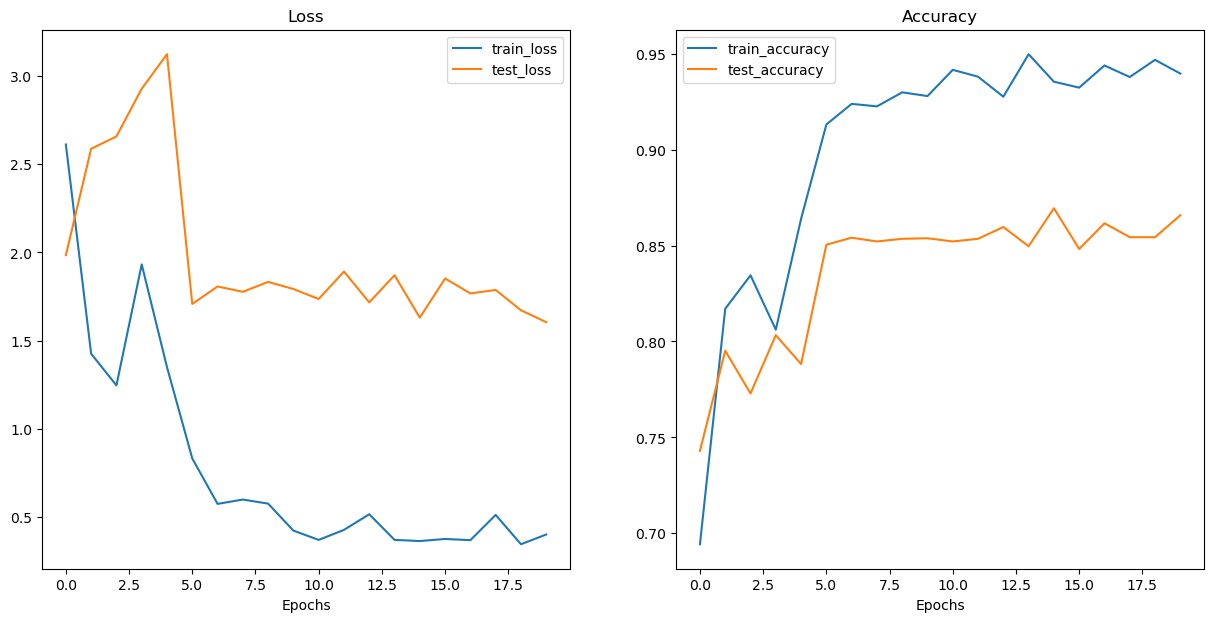

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet50_results)